# Light Curve Accuracy Tests

Goal: We need to define some criteria for a "detection," which is going to be related to how bright the source is relative to the detection limit. For now, let's be conservative and say a source is detected only if it is brighter than the limits you found by 0.5 mag. Let's also start by observing in only a single filter. So, to simulate observations I'd like for you to do the following - pick a rondom number between 0 and 24 (this is the time in hours after which LIGO detected the event). Then observe the light curve (for now just use the z = 0.015 model, though we will vary this eventually) in one of the filters, do this again 24 hr later, and 6 d after that. If we "detect" the source in each of the first 2 observations, but we do not detect the source in the last observation, consider the source "discovered". What we are now trying to make is a histogram as a function of 0-24 hr for each filter for how likely we are to detect the kilonova. 


In [3]:
#Necessary files needed for plotting the curves and manipulating the data.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astropy as astro
from astropy.table import Table,Column
from astropy.io import ascii
from astropy.cosmology import WMAP9 as cosmo
from scipy.interpolate import interp1d
plt.rcParams["figure.figsize"] = (10,8)

#We will need to grab the data from where it is saved on the computer.

#NS-NS
APR1215 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1215.txt')
APR1314 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1314.txt')
H41215 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1215.txt')
H41314 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1314.txt')
Sly135 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/Sly-135.txt')

#NS-BH
APR4Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4Q3a75.txt')
H4Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4Q3a75.txt')
MS1Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q3a75.txt')
MS1Q7a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q7a75.txt')

## Light Curve Plots (with Individual Band Plots)

In [4]:
#Convert Absolute Magnitude to Apparent Magnitude

#app_mag: Merger Number -> Merger
#Converts the merger data from absolute magnitude to apparent magnitude.
def app_mag(merger, redshift):
    merger['u']=app_mag_band(merger['u'],redshift)
    merger['g']=app_mag_band(merger['g'],redshift)
    merger['r']=app_mag_band(merger['r'],redshift)
    merger['i']=app_mag_band(merger['i'],redshift)
    merger['z']=app_mag_band(merger['z'],redshift)
    return merger

#app_mag_band: ListofNumbers Number -> ListofNumbers
#converts all the absolute magnitudes into apparent magnitudes.
def app_mag_band(data, redshift):
    return 5*np.log10(lumo_dist(redshift)/10)+data

#lumo_dist: Number -> Number
#converts redshift to luminosity distance
def lumo_dist(redshift):
    return cosmo.luminosity_distance(redshift).to(astro.units.pc).value


#NS-NS Conversions:
APR1215_app=app_mag(APR1215, 0.015)
APR1314_app=app_mag(APR1314, 0.015)
H41215_app=app_mag(H41215, 0.015)
H41314_app=app_mag(H41314, 0.015)
Sly135_app=app_mag(Sly135, 0.015)

#NS-BH Conversions:
APR4Q3a75_app=app_mag(APR4Q3a75, 0.015)
H4Q3a75_app=app_mag(H4Q3a75, 0.015)
MS1Q3a75_app=app_mag(MS1Q3a75, 0.015)
MS1Q7a75_app=app_mag(MS1Q7a75, 0.015)

In [5]:
#full_plot: Merger String String -> Image
#Takes the data from the Merger and plots the magnitudes and interpolations of each associated photometric band as a
# function of time measured in days.
def full_plot(merger,name):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    abs_plotter1(merger)
    abs_plot_interp(merger)
    LSST_plot(merger)
    ax.axis([0,35,rounded_up(correct_max(merger))+5,(rounded_down(correct_min(merger))-5)])
    plt.title("Light Curve of " + name, fontsize=18)
    plt.xlabel("Time (Days)", fontsize=14)
    plt.ylabel('Magnitude', fontsize=14)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    return

#abs_plotter1 Merger -> Image
#Plots the data from the ascii.reads of the merger.
def abs_plotter1(merger):
    plot_band(merger, 'u', '.', 'b')
    plot_band(merger, 'g', '.', 'g')
    plot_band(merger, 'r', '.', 'y')
    plot_band(merger, 'i', '.', 'orange')
    plot_band(merger, 'z', '.', 'r')
    return

#plot_band: Merger String String String -> Image
#Plots the magnitudes of a photometric band in the merger.
def plot_band(merger, name, style, color):
    plt.plot(merger['day'], merger[name], style, color=color, label=name)

#abs_plotter1 Merger -> Image
#Plots the interpolations calculated from data from the ascii.reads of the merger.
def abs_plot_interp(merger):
    plot_interp(merger, 'u', '--', 'b', 0)
    plot_interp(merger, 'g', '--', 'g', 1)
    plot_interp(merger, 'r', '--', 'y', 2)
    plot_interp(merger, 'i', '--', 'orange', 3)
    plot_interp(merger, 'z', '--', 'r', 4)
    return

#plot_band: Merger String String String Number -> Image
#Plots the interpolation of a photometric band in the merger.
def plot_interp(merger, name, style, color, number):
    plt.plot(day_new(merger, name), interpolate(merger)[number](day_new(merger, name)),
             style, color=color, label=name+' interp.')
    return

#interpolate: Merger-> List of Interpolations
#Provides the necessary interpolation functions of the mergers in each associated photometric bands. 
def interpolate(merger):
    LSST_u=23.9
    LSST_g=25.0
    LSST_r=24.7
    LSST_i=24.0
    LSST_z=23.3
    approx='cubic'
    u=interp1d(merger['day'][np.isfinite(merger['u'])], merger['u'][np.isfinite(merger['u'])],
               kind=approx, bounds_error=False, fill_value=LSST_u)
    g=interp1d(merger['day'][np.isfinite(merger['g'])], merger['g'][np.isfinite(merger['g'])],
               kind=approx, bounds_error=False, fill_value=LSST_g)
    r=interp1d(merger['day'][np.isfinite(merger['r'])], merger['r'][np.isfinite(merger['r'])],
               kind=approx, bounds_error=False, fill_value=LSST_r)
    i=interp1d(merger['day'][np.isfinite(merger['i'])], merger['i'][np.isfinite(merger['i'])],
               kind=approx, bounds_error=False, fill_value=LSST_i)
    z=interp1d(merger['day'][np.isfinite(merger['z'])], merger['z'][np.isfinite(merger['z'])],
               kind=approx, bounds_error=False, fill_value=LSST_z)
    return [u, g, r, i, z]

#day_new Merger String -> List of Numbers
#Produces a new set of points between the range of the 'day' column in the merger data. This is useful for plotting
# the interpolations.
def day_new(merger, band):
    set_length=100
    day_new = np.linspace(min(merger['day'][np.isfinite(merger[band])]),
                          max(merger['day'][np.isfinite(merger[band])]),set_length)
    return day_new

#LSST_plot: Merger -> Image
#Plots graphs of the LSST's 5-sigma depths in all five bands.
def LSST_plot(merger):
    LSST_u=(merger['day']/merger['day'])-1+23.9
    LSST_g=(merger['day']/merger['day'])-1+25.0
    LSST_r=(merger['day']/merger['day'])-1+24.7
    LSST_i=(merger['day']/merger['day'])-1+24.0
    LSST_z=(merger['day']/merger['day'])-1+23.3
    plt.plot(merger['day'], LSST_u, 'b', label='LSST \n u-band')
    plt.plot(merger['day'], LSST_g, 'g', label='LSST \n g-band')
    plt.plot(merger['day'], LSST_r, 'y', label='LSST \n r-band')
    plt.plot(merger['day'], LSST_i, 'orange', label='LSST \n i-band')
    plt.plot(merger['day'], LSST_z, 'r', label='LSST \n z-band')
    return

#correct_max: Merger -> Number
#Outputs the largest magnitude in the entire merger data.
def correct_max(merger):
    max_list = [max(merger['u'][np.isfinite(merger['u'])]), 
                max(merger['g'][np.isfinite(merger['g'])]), 
                max(merger['r'][np.isfinite(merger['r'])]),
                max(merger['i'][np.isfinite(merger['i'])]),
                max(merger['z'][np.isfinite(merger['z'])])]
    return max(max_list)

#correct_min: Merger -> Number
#Outputs the smallest magnitude in the entire merger data.
def correct_min(merger):
    min_list = [min(merger['u'][np.isfinite(merger['u'])]), 
                min(merger['g'][np.isfinite(merger['g'])]), 
                min(merger['r'][np.isfinite(merger['r'])]),
                min(merger['i'][np.isfinite(merger['i'])]),
                min(merger['z'][np.isfinite(merger['z'])])]
    return min(min_list)

#round_up: number base -> number
#Rounds the number up to the nearest multiple of the base number.
def rounded_up(x, base=5):
    return int(base * (round(float(x)/base)+1))

#round_down: number base -> number
#Rounds the number down to the nearest multiple of the base number.
def rounded_down(x, base=5):
    return int(base * (round(float(x)/base)))

In [6]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(1)

bands=['u','g','r', 'i', 'z']

#rand_plot: Merger String String String -> Image
#Plots a randomly chosen band from the merger.
def band_plot(merger, name):
    LSST_u=(merger['day']/merger['day'])-1+23.9
    LSST_g=(merger['day']/merger['day'])-1+25.0
    LSST_r=(merger['day']/merger['day'])-1+24.7
    LSST_i=(merger['day']/merger['day'])-1+24.0
    LSST_z=(merger['day']/merger['day'])-1+23.3
    fig=plt.figure(figsize=(8.72,25))
    for band in bands:
        if band == 'u':
            band_graph(merger, 'u', 'b', 511, 0, LSST_u)
        elif band == 'g':
            band_graph(merger, 'g', 'g', 512, 1, LSST_g)
        elif band == 'r':
            band_graph(merger, 'r', 'y', 513, 2, LSST_r)
        elif band == 'i':
            band_graph(merger, 'i', 'orange', 514, 3, LSST_i)
        elif band == 'z':
            band_graph(merger, 'z', 'r', 515, 4, LSST_z)
    plt.suptitle("Light Curve Bands of " + name, fontsize=18, y=1.01)
    plt.tight_layout()
    return

def band_graph(merger, band, color, sub_num, num, LSST_band):
    ax = plt.subplot(sub_num)
    plot_band(merger, band, '.', color)
    plot_interp(merger, band, '--', color, num)
    plt.plot(merger['day'], LSST_band, color, label='LSST (' + band + ')')
    plt.axis([0,35,rounded_up(correct_max(merger))+5,(rounded_down(correct_min(merger))-5)])
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.xlabel("Time (Days)", fontsize=14)
    plt.ylabel('Magnitude', fontsize=14)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    return

### NS-NS Mergers (Apparent Magnitude)

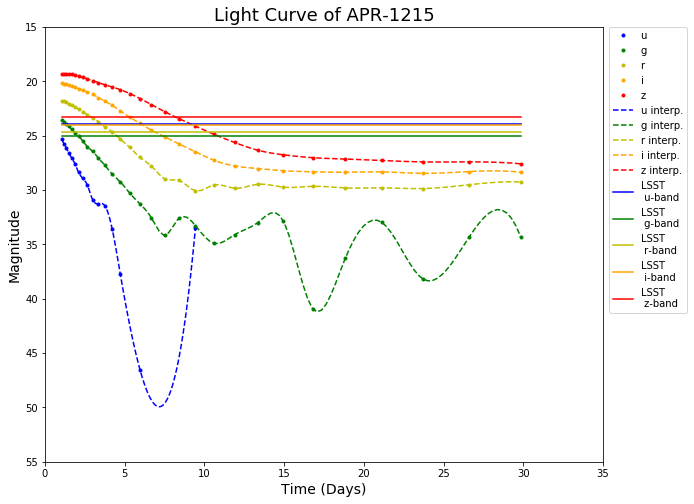

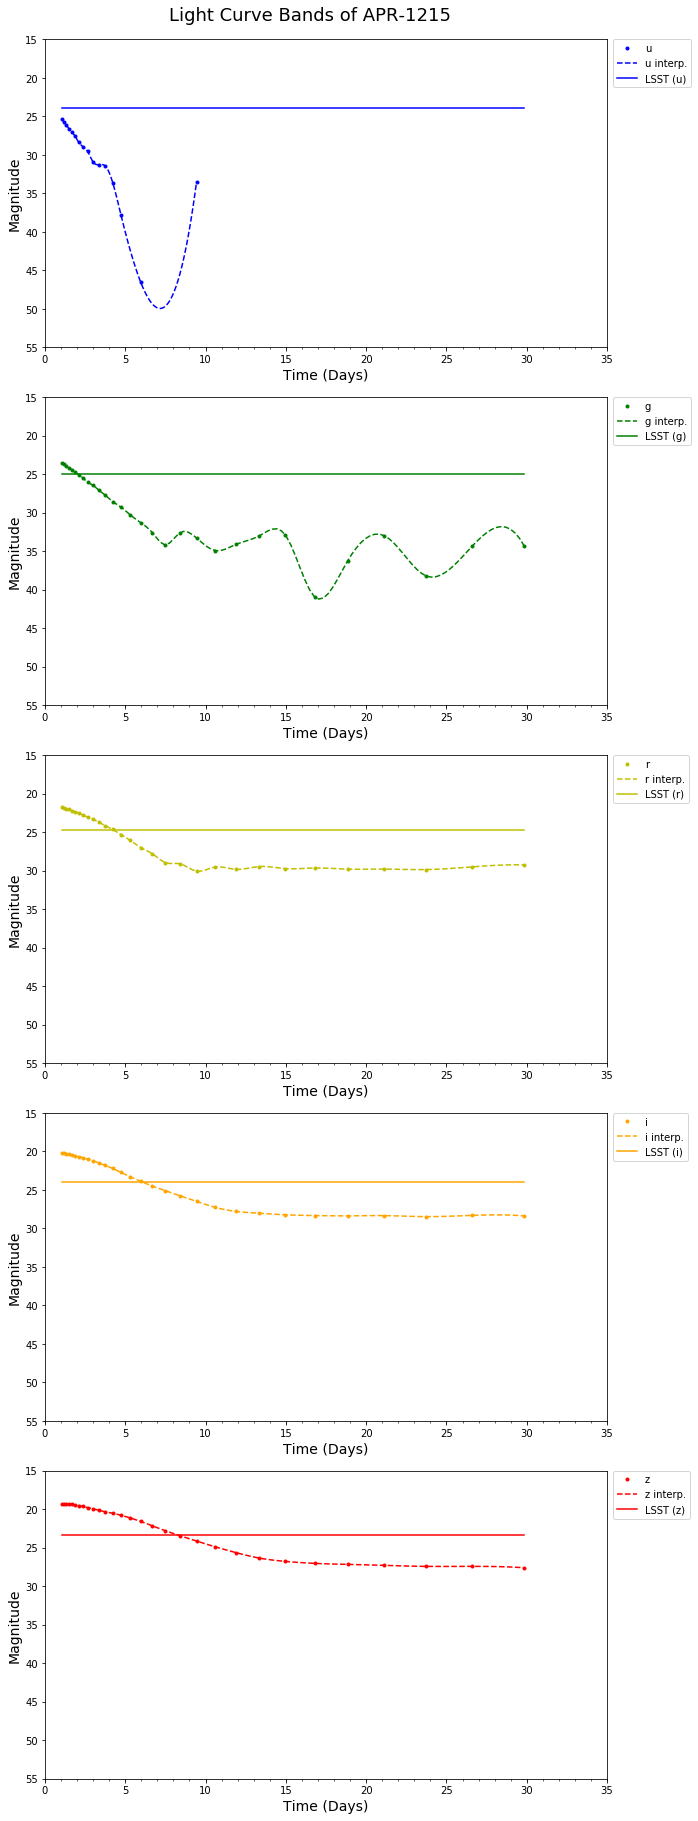

In [7]:
#The following are plots of only the data and the interpolations retrived from the data files in the ascii.reads, 
# converted into apparent magnitude.
full_plot(APR1215_app, "APR-1215")
band_plot(APR1215_app, "APR-1215")

In [310]:
full_plot(APR1314_app, "APR4-1314")
plt.close()
band_plot(APR1314_app, "APR4-1314")
plt.close()

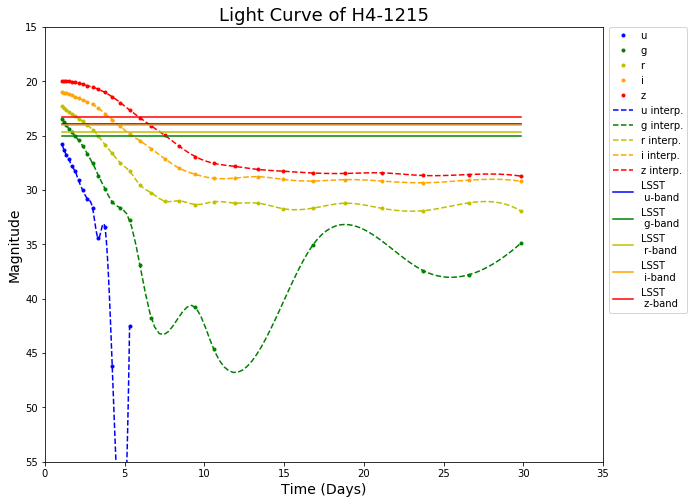

In [464]:
full_plot(H41215_app, "H4-1215")

band_plot(H41215_app, "H4-1215")
plt.close()

In [97]:
full_plot(H41314_app, "H4-1314")
plt.close()
band_plot(H41314_app, "H4-1314")
plt.close()

In [306]:
full_plot(Sly135_app, "Sly-135")
plt.close()
band_plot(Sly135_app, "Sly-135")
plt.close()

### NS-BH Mergers (Apparent Magnitude)

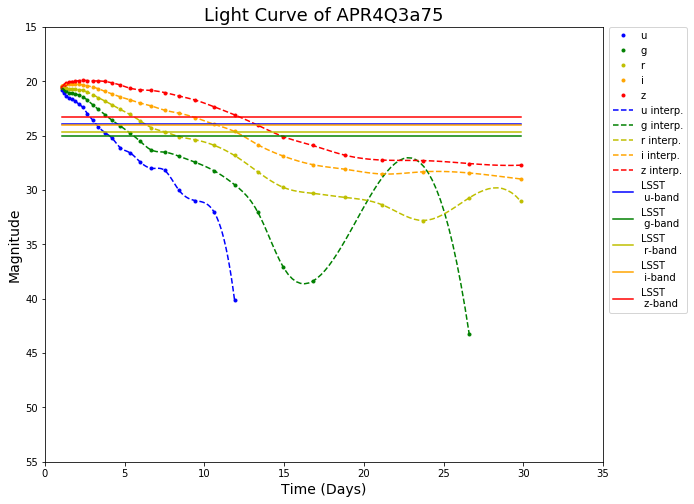

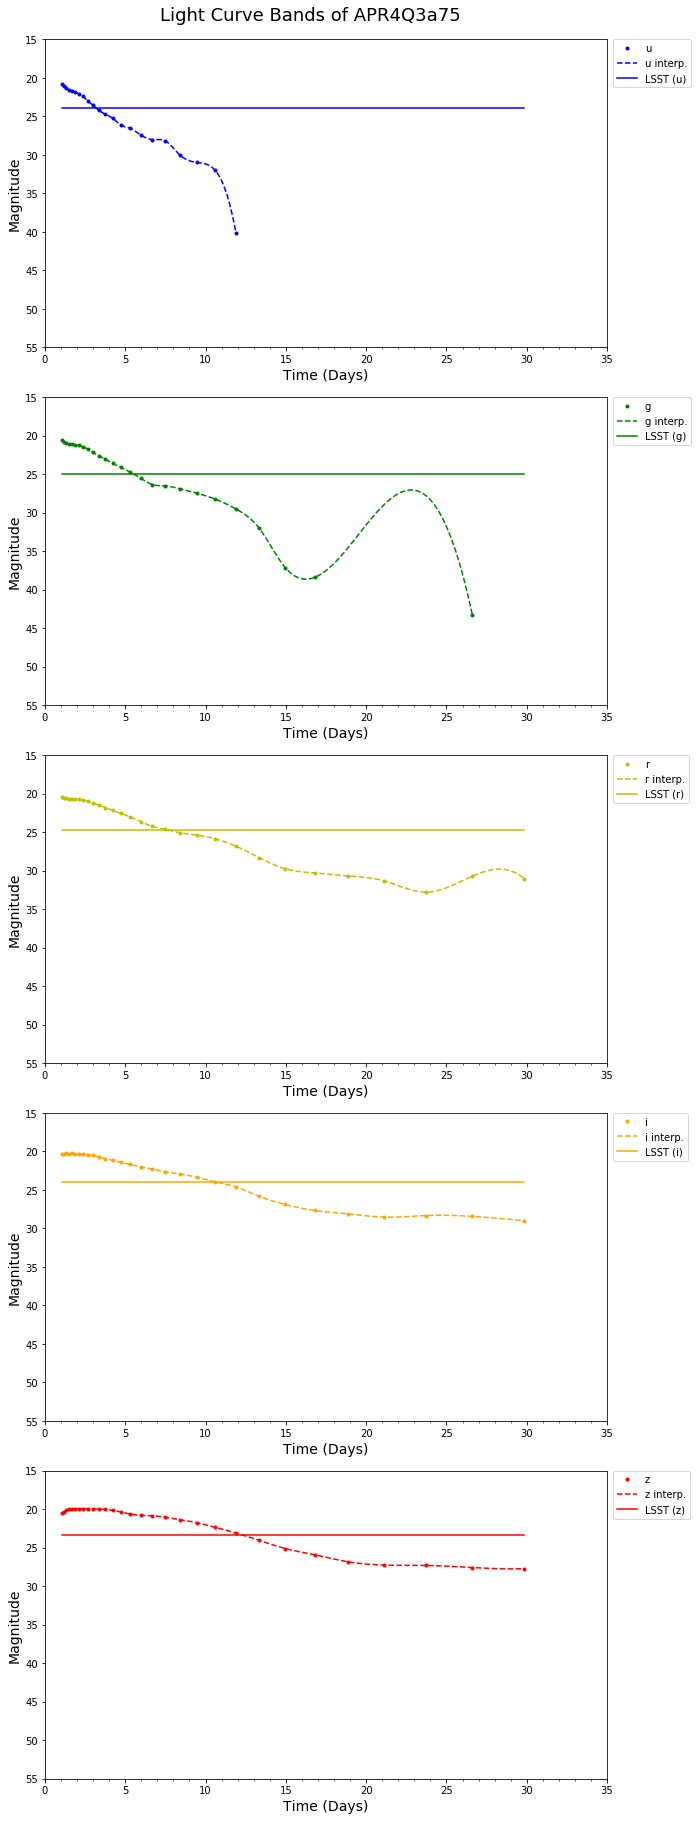

In [10]:
#The following are plots of only the data and the interpolations retrived from the data files in the ascii.reads, 
# converted into apparent magnitude.
full_plot(APR4Q3a75_app, 'APR4Q3a75')
band_plot(APR4Q3a75_app, 'APR4Q3a75')

In [14]:
full_plot(H4Q3a75_app, 'H4Q3a75')
plt.close()
band_plot(H4Q3a75_app, 'H4Q3a75')
plt.close()

In [12]:
full_plot(MS1Q3a75_app, 'MS1Q3a75')
plt.close()
band_plot(MS1Q3a75_app, 'MS1Q3a75')
plt.close()

In [91]:
full_plot(MS1Q7a75_app, 'MS1Q7a75')
plt.close()
band_plot(MS1Q7a75_app, 'MS1Q7a75')
plt.close()

## Random Detections

In [651]:
import random

#Constants:
LSST_u=23.9
LSST_g=25.0
LSST_r=24.7
LSST_i=24.0
LSST_z=23.3

trial_num=1000
epoch2=1
epoch3=2

bands=['u','g','r', 'i', 'z']

In [652]:
#Analyze: Merger -> Table
#Randomly runs 1,000 trials can places the information of the type of band, the distance, and the kilonova detection
# (0=fail; 1=success) into a table.
def Analyze(merger, epoch2, epoch3, trial_num, bands):
    t_0 = [random.random()+1.06 for x in range(trial_num)]
    band_list=[]
    dist_list=[]
    detect_list=[]
    m0=[]
    m1=[]
    m7=[]
    epoch_2 = [t+epoch2 for t in t_0]
    epoch_3 = [t+epoch3 for t in t_0]
    for t in t_0:
        band=random.choice(bands)
        band_list.append(band)
        dist_list.append(rand_dist(merger))
        m0.append(get_mag(merger, band, t))
        m1.append(get_mag(merger, band, t+epoch2))
        m7.append(get_mag(merger, band, t+epoch3))
        if rand_detect(merger, band, t, epoch2, epoch3) == True:
            detect_list.append(1)
        else:
            detect_list.append(0)
    return Table([band_list, dist_list, t_0, epoch_2, epoch_3, m0, m1, m7, detect_list], 
                 names=('Band', 'Distance', 'Epoch 1 (Days)', 'Epoch 2 (Days)', 'Epoch 3 (Days)',
                        'Magnitude\n(Epoch 1)', 'Magnitude\n(Epoch 2)', 'Magnitude\n(Epoch 3)','Kilonova Hit')) 

#rand_dist: Merger -> Number
#Picks a random distance from 0 to 200Mpc.
def rand_dist(merger):
    x=random.uniform(-1,1)
    y=random.uniform(-1,1)
    z=random.uniform(-1,1)
    dist=np.sqrt(x**2+y**2+z**2)
    if dist < 1:
        return dist*200
    else:
        return rand_dist(merger)
    return

#rand_detect: Merger String -> Boolean
#Determines whether a Kilonova is detected or not.
def rand_detect(merger, band, time, epoch2, epoch3):
    if detect(merger, band, time) and detect(merger, band, time+epoch2) and not detect(merger, band, time+epoch3):
        return True
    else:
        return False
    return

#detect: Merger String Number -> Boolean
#Determines if LSST can detect the light curve of a specific band at a specific time.
def detect(merger, band, time):
    if band == 'u':
        mag_u = interpolate(merger)[0](time)+0.5
        return in_view(mag_u, LSST_u)
    elif band == 'g':
        mag_g = interpolate(merger)[1](time)+0.5
        return in_view(mag_g, LSST_g)
    elif band == 'r':
        mag_r = interpolate(merger)[2](time)+0.5
        return in_view(mag_r, LSST_r)
    elif band == 'i':
        mag_i = interpolate(merger)[3](time)+0.5
        return in_view(mag_i, LSST_i)
    elif band == 'z':
        mag_z = interpolate(merger)[4](time)+0.5
        return in_view(mag_z, LSST_z)
    return

#in_view: Number Number -> Boolean
#Checks if LSST can detect the light curve based on magnitude.
def in_view(mag, LSST):
    if mag < LSST:
        return True
    else:
        return False
    return


def get_mag(merger, band, time):
    if detect(merger, band, time)==True:
        if band == 'u':
            mag = interpolate(merger)[0](time)+0.5
        elif band == 'g':
            mag = interpolate(merger)[1](time)+0.5
        elif band == 'r':
            mag = interpolate(merger)[2](time)+0.5
        elif band == 'i':
            mag = interpolate(merger)[3](time)+0.5
        elif band == 'z':
            mag = interpolate(merger)[4](time)+0.5
    
    elif detect(merger, band, time)==False:
        if band == 'u':
            mag = LSST_u
        elif band == 'g':
            mag = LSST_g
        elif band == 'r':
            mag = LSST_r
        elif band == 'i':
            mag = LSST_i
        elif band == 'z':
            mag = LSST_z
    
    return mag

        

In [653]:
#NS-NS Mergers
APR1215_table =Analyze(APR1215_app, epoch2, epoch3, trial_num, bands)

In [654]:
APR1314_table = Analyze(APR1314_app, epoch2, epoch3, trial_num, bands)

In [655]:
H41215_table = Analyze(H41215_app, epoch2, 3, trial_num, bands)

In [656]:
H41314_table = Analyze(H41314_app, epoch2, epoch3, trial_num, bands)

In [657]:
Sly135_table = Analyze(Sly135_app, epoch2, epoch3, trial_num, bands)

In [658]:
#NS-BH Mergers
APR4Q3a75_table = Analyze(APR4Q3a75_app, epoch2, epoch3, trial_num, bands)

In [659]:
H4Q3a75_table = Analyze(H4Q3a75_app, epoch2, epoch3, trial_num, bands)

In [660]:
MS1Q3a75_table = Analyze(MS1Q3a75_app, epoch2, epoch3, trial_num, bands)

In [661]:
MS1Q7a75_table = Analyze(MS1Q7a75_app, epoch2, epoch3, trial_num, bands)

In [662]:
def total_efficiency(table, merger_base, epoch2, epoch3):
    table[np.where(table['Band']=='u')] = band_efficiency(table[np.where(table['Band']=='u')], 'u', merger_base, epoch2, epoch3, LSST_u)
    table[np.where(table['Band']=='g')] = band_efficiency(table[np.where(table['Band']=='g')], 'g', merger_base, epoch2, epoch3, LSST_g)
    table[np.where(table['Band']=='r')] = band_efficiency(table[np.where(table['Band']=='r')], 'r', merger_base, epoch2, epoch3, LSST_r)
    table[np.where(table['Band']=='i')] = band_efficiency(table[np.where(table['Band']=='i')], 'i', merger_base, epoch2, epoch3, LSST_i)
    table[np.where(table['Band']=='z')] = band_efficiency(table[np.where(table['Band']=='z')], 'z', merger_base, epoch2, epoch3, LSST_z)
    return table


def band_efficiency(table, band, merger_base, epoch2, epoch3, LSST):
    if all([item==LSST for item in table['Magnitude\n(Epoch 2)']]):
        return table
    elif any([item==LSST for item in table['Magnitude\n(Epoch 2)']]):
        return table
    else:
        new_table=efficiency(table, band)    
        if all([item==0 for item in new_table]):
            epoch3 +=1
            return band_efficiency(
                Analyze(merger_base, epoch2, epoch3, len(table), [band]), band, merger_base, epoch2, epoch3, LSST)
        elif all([item==100 or item==0 for item in new_table]):
            return table
        else:
            epoch3 +=1
            return band_efficiency(
                Analyze(merger_base, epoch2, epoch3, len(table), [band]), band, merger_base, epoch2, epoch3, LSST)


#efficiency: Table String -> ListofNumbers
#Converts the number of detections into a fraction: number of succesful detections over the total number of
# observations at that distance.
def efficiency(merger_table, band):
    countx, binx=np.histogram(np.array(filter_dist(filter_band(filter_hits(merger_table), band))),
                              bins=50, range=(0,200))
    county, biny=np.histogram(np.array(filter_dist(filter_band(merger_table, band))), bins=50, range=(0,200))
    np.seterr(divide='ignore', invalid='ignore')
    counts=countx/county
    for i in range(len(counts)):
        if np.isnan(counts[i]):
            counts[i]=0
    return counts*100

In [663]:
#NS-NS Mergers
APR1215_eff = total_efficiency(APR1215_table, APR1215_app, epoch2, epoch3)

In [664]:
APR1314_eff = total_efficiency(APR1314_table, APR1314_app, epoch2, epoch3)

In [665]:
H41215_eff = total_efficiency(H41215_table, H41215_app, epoch2, epoch3)

In [666]:
H41314_eff = total_efficiency(H41314_table, H41314_app, epoch2, epoch3)

In [667]:
Sly135_eff = total_efficiency(Sly135_table, Sly135_app, epoch2, epoch3)

In [668]:
#NS-BH Mergers
APR4Q3a75_eff = total_efficiency(APR4Q3a75_table, APR4Q3a75_app, epoch2, epoch3)

In [669]:
H4Q3a75_eff = total_efficiency(H4Q3a75_table,  H4Q3a75_app, epoch2, epoch3)

In [670]:
MS1Q3a75_eff = total_efficiency(MS1Q3a75_table,  MS1Q3a75_app, epoch2, epoch3)

In [671]:
MS1Q7a75_eff = total_efficiency(MS1Q7a75_table,  MS1Q7a75_app, epoch2, epoch3)

In [672]:
def max_day(table):
    u=max_day_band(filter_band(table, 'u'))
    g=max_day_band(filter_band(table, 'g'))
    r=max_day_band(filter_band(table, 'r'))
    i=max_day_band(filter_band(table, 'i'))
    z=max_day_band(filter_band(table, 'z'))
    return [u, g, r, i, z]

def max_day_band(table):
    day = np.subtract(table['Epoch 3 (Days)'], table['Epoch 1 (Days)'])
    return day[0]

## Detection Histograms

In [737]:
#plot_hist: Table String -> Image
#Plots a histogram of the number of Kilonova detections for each range of distance (Mpc).
def plot_hist(table, name):
    ax1 = plot_dimension(table, 'u', 0)
    ax2 = plot_dimension(table, 'g', 1)
    ax3 = plot_dimension(table, 'r', 2)
    ax4 = plot_dimension(table, 'i', 3)
    ax5 = plot_dimension(table, 'z', 4)
    ax1.hist(np.array(filter_dist(filter_band(filter_hits(table), 'u'))),
             bins=49, range=(0,200), facecolor='blue', edgecolor='black', label='u')
    
    ax2.hist(np.array(filter_dist(filter_band(filter_hits(table), 'g'))), 
             bins=49, range=(0,200), facecolor='green', edgecolor='black', label='g')
    
    ax3.hist(np.array(filter_dist(filter_band(filter_hits(table), 'r'))), 
             bins=49, range=(0,200), facecolor='yellow', edgecolor='black', label='r')
    
    ax4.hist(np.array(filter_dist(filter_band(filter_hits(table), 'i'))),
             bins=49, range=(0,200), facecolor='orange', edgecolor='black', label='i')
    
    ax5.hist(np.array(filter_dist(filter_band(filter_hits(table), 'z'))), 
             bins=49, range=(0,200), facecolor='red', edgecolor='black', label='z')
    ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax4.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax5.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.suptitle(name, fontsize=18, y=1.05)
    ax1.set_xlabel('Distance (Mpc)', fontsize=14)
    ax1.set_ylabel('Detections')
    ax2.set_xlabel('Distance (Mpc)', fontsize=14)
    ax2.set_ylabel('Detections')
    ax3.set_xlabel('Distance (Mpc)', fontsize=14)
    ax3.set_ylabel('Detections')
    ax4.set_xlabel('Distance (Mpc)', fontsize=14)
    ax4.set_ylabel('Detections')
    ax5.set_xlabel('Distance (Mpc)', fontsize=14)
    ax5.set_ylabel('Detections')
    plt.tight_layout()
    return 

#filter_hits: Table -> Table
#Filters the table to only have data containing kilonova hits.
def filter_hits(table):
    hits = np.where(table['Kilonova Hit'] == 1)[0]
    return table[hits]

#filter_band: Table String -> Table
#Filters the table to only have data containing the designated band.
def filter_band(table, band):
    band_filter=np.where(table['Band']==band)[0]
    return table[band_filter]

#filter_hits: Table -> Table
#Filters the table to only have data containing the distance (Mpc).
def filter_dist(table):
    return table['Distance']

from matplotlib import gridspec

def plot_dimension(table, band, number):
    gs = gridspec.GridSpec(5, 5)
    new_table=efficiency(table, band)
    if all([item==0 for item in new_table]):
        ax = plt.subplot(gs[number, 0])
    else:
        ax = plt.subplot(gs[number, :])
    return ax


def epoch_table(table):
    return Table([bands, max_day(table)], names=('Bands', 'Epoch 3 \n (Days)'))

### NS-NS Detection Plots

Bands,Epoch 3 (Days)
str1,float64
u,2.0
g,2.0
r,3.0
i,5.0
z,7.0


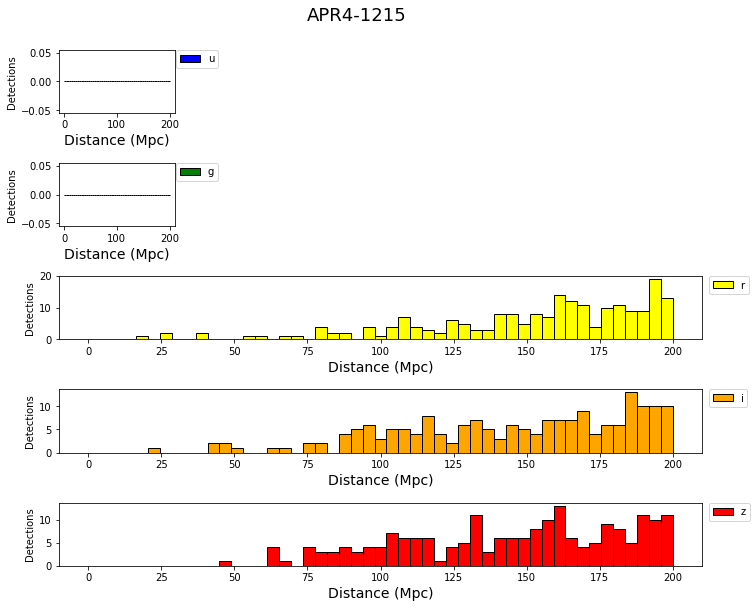

In [738]:
plot_hist(APR1215_eff, "APR4-1215")
epoch_table(APR1215_eff)

In [739]:
plot_hist(APR1314_eff, "APR4-1314")
epoch_table(APR1314_eff)
plt.close()

In [676]:
plot_hist(H41215_eff, "H4-1215")
epoch_table(H41215_eff)
plt.close()

In [677]:
plot_hist(H41314_eff, "H4-1314")
epoch_table(H41314_eff)
plt.close()

In [678]:
plot_hist(Sly135_eff, "Sly-135")
epoch_table(Sly135_eff)
plt.close()

### NS-BH Detection Plots

Bands,Epoch 3 (Days)
str1,float64
u,2.0
g,5.0
r,6.0
i,9.0
z,11.0


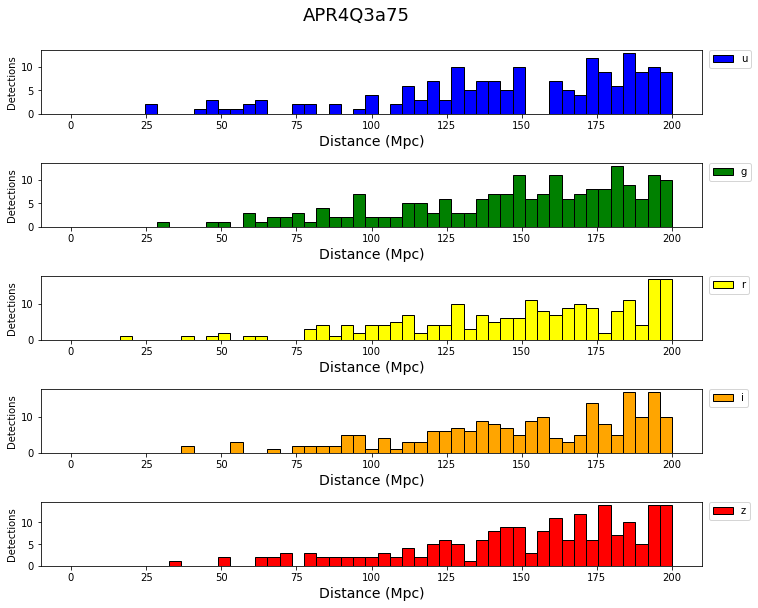

In [680]:
plot_hist(APR4Q3a75_eff, "APR4Q3a75")
epoch_table(APR4Q3a75_eff)

In [681]:
plot_hist(H4Q3a75_eff, "H4Q3a75")
epoch_table(H4Q3a75_eff)
plt.close()

In [687]:
plot_hist(MS1Q3a75_eff, "MS1Q3a75")
epoch_table(MS1Q3a75_eff)
plt.close()

In [685]:
plot_hist(MS1Q7a75_eff, "MS1Q7a75")
epoch_table(MS1Q7a75_eff)
plt.close()

## Efficiency Plots

In [542]:
#Constants:
bar_width=3
distance=np.linspace(0,200,50)

#plot_bar: Table String -> Image
#Plots a bar graph of the efficiency of the LSST as a function of distance(Mpc).
def plot_bar(table, name):
    ax1 = plot_dimension(table, 'u', 0)
    ax2 = plot_dimension(table, 'g', 1)
    ax3 = plot_dimension(table, 'r', 2)
    ax4 = plot_dimension(table, 'i', 3)
    ax5 = plot_dimension(table, 'z', 4)
    ax1.bar(distance, efficiency(table, 'u'),
           width=bar_width, align='center', facecolor='blue', edgecolor='black', label='u')
    
    ax2.bar(distance, efficiency(table, 'g'),
            width=bar_width, align='center', facecolor='green', edgecolor='black', label='g')
    
    ax3.bar(distance, efficiency(table, 'r'),
            width=bar_width, align='center', facecolor='yellow', edgecolor='black', label='r')
    
    ax4.bar(distance, efficiency(table, 'i'),
            width=bar_width, align='center', facecolor='orange', edgecolor='black', label='i')
    
    ax5.bar(distance, efficiency(table, 'z'),
           width=bar_width, align='center', facecolor='red', edgecolor='black', label='z')
    
    ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax4.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax5.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    
    plt.suptitle(name, fontsize=18, y=1.05)
    ax1.set_xlabel('Distance (Mpc)', fontsize=14)
    ax1.set_ylabel('Efficiency(%)')
    ax2.set_xlabel('Distance (Mpc)', fontsize=14)
    ax2.set_ylabel('Efficiency(%)')
    ax3.set_xlabel('Distance (Mpc)', fontsize=14)
    ax3.set_ylabel('Efficiency(%)')
    ax4.set_xlabel('Distance (Mpc)', fontsize=14)
    ax4.set_ylabel('Efficiency(%)')
    ax5.set_xlabel('Distance (Mpc)', fontsize=14)
    ax5.set_ylabel('Efficiency(%)')
    plt.tight_layout()
    return

### NS-NS Efficiency Plots

Bands,Epoch 3 (Days)
str1,float64
u,2.0
g,2.0
r,3.0
i,5.0
z,7.0


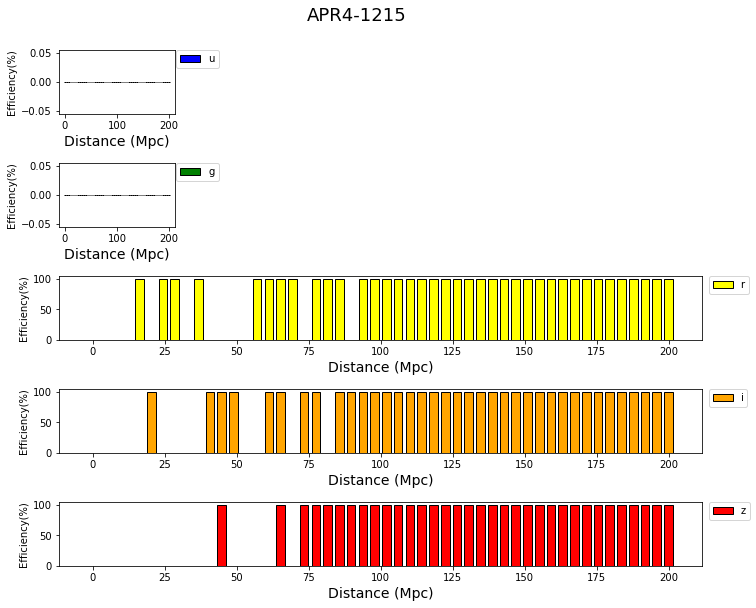

In [689]:
plot_bar(APR1215_eff, "APR4-1215")
epoch_table(APR1215_eff)

In [691]:
plot_bar(APR1314_eff, "APR4-1314")
epoch_table(APR1314_eff)
plt.close()

In [692]:
plot_bar(H41215_eff, "H4-1215")
epoch_table(H41215_eff)
plt.close()

In [693]:
plot_bar(H41314_eff, "H4-1314")
epoch_table(H41314_eff)
plt.close()

In [694]:
plot_bar(Sly135_eff, "Sly-135")
epoch_table(Sly135_eff)
plt.close()

### NS-BH Efficiency Plots

Bands,Epoch 3 (Days)
str1,float64
u,2.0
g,5.0
r,6.0
i,9.0
z,11.0


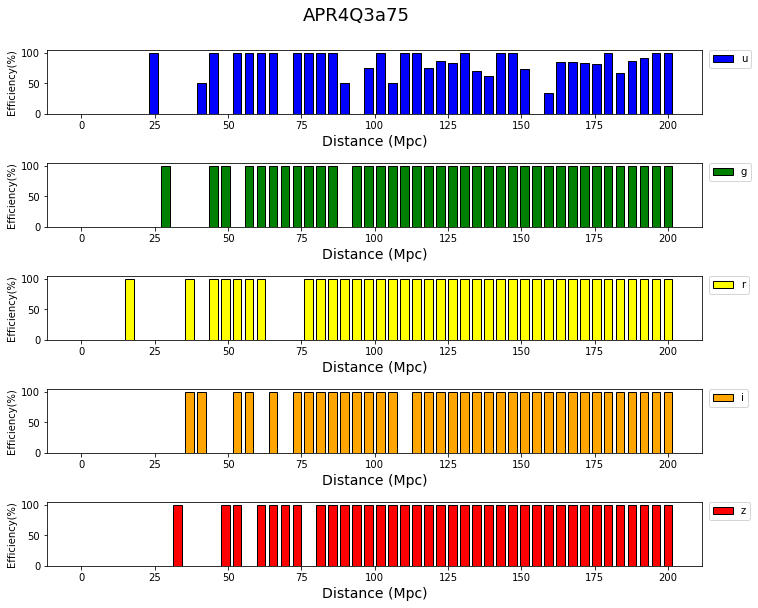

In [695]:
plot_bar(APR4Q3a75_eff, "APR4Q3a75")
epoch_table(APR4Q3a75_eff)

In [696]:
plot_bar(H4Q3a75_eff, "H4Q3a75")
epoch_table(H4Q3a75_eff)
plt.close()

In [697]:
plot_bar(MS1Q3a75_eff, "MS1Q3a75")
epoch_table(MS1Q3a75_eff)
plt.close()

In [699]:
plot_bar(MS1Q7a75_eff, "MS1Q7a75")
epoch_table(MS1Q7a75_eff)
plt.close()

## $\boldsymbol{\Delta \textbf{m}_{1}}$ Plots

In [700]:
#filter_hits: Table -> Table
#Filters the table to only have data containing kilonova hits.
def filter_hits(table):
    hits = np.where(table['Kilonova Hit'] == 1)[0]
    return table[hits]

#filter_band: Table String -> Table
#Filters the table to only have data containing the designated band.
def filter_band(table, band):
    band_filter=np.where(table['Band']==band)[0]
    return table[band_filter]


def filter_mags(table):
    return table['Magnitude\n(Epoch 1)', 'Magnitude\n(Epoch 2)', 'Magnitude\n(Epoch 3)']

def delta_m1_band(table, band):
    m1 = np.subtract(filter_mags(filter_band(table, band))['Magnitude\n(Epoch 2)'],
                     filter_mags(filter_band(table, band))['Magnitude\n(Epoch 1)'])
    return m1

def plot_m1(table, name):
    ax1 = plt.subplot(511)
    ax2 = plt.subplot(512)
    ax3 = plt.subplot(513)
    ax4 = plt.subplot(514)
    ax5 = plt.subplot(515)
    ax1.hist(np.array(delta_m1_band(table, 'u')),
             bins=75, range=(0, np.ceil(max_delta(table))), facecolor='blue', edgecolor='black', label='u')
    
    ax2.hist(np.array(delta_m1_band(table, 'g')), 
             bins=75, range=(0, np.ceil(max_delta(table))), facecolor='green', edgecolor='black', label='g')
    
    ax3.hist(np.array(delta_m1_band(table, 'r')), 
             bins=75, range=(0, np.ceil(max_delta(table))), facecolor='yellow', edgecolor='black', label='r')
    
    ax4.hist(np.array(delta_m1_band(table, 'i')),
             bins=75, range=(0, np.ceil(max_delta(table))), facecolor='orange', edgecolor='black', label='i')
    
    ax5.hist(np.array(delta_m1_band(table, 'z')), 
             bins=75, range=(0, np.ceil(max_delta(table))), facecolor='red', edgecolor='black', label='z')
    
    ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax4.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax5.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.suptitle(name, fontsize=18, y=1.05)
    ax1.set_ylabel('Frequency', fontsize=14)
    ax1.set_xlabel('$Δm_{1}$', fontsize=16)
    ax2.set_ylabel('Frequency', fontsize=14)
    ax2.set_xlabel('$Δm_{1}$', fontsize=16)
    ax3.set_ylabel('Frequency', fontsize=14)
    ax3.set_xlabel('$Δm_{1}$', fontsize=16)
    ax4.set_ylabel('Frequency', fontsize=14)
    ax4.set_xlabel('$Δm_{1}$', fontsize=16)
    ax5.set_ylabel('Frequency', fontsize=14)
    ax5.set_xlabel('$Δm_{1}$', fontsize=16)
    plt.tight_layout()
    return

def max_delta(table):
    u = check_empty(np.array(delta_m1_band(table, 'u')))
    g = check_empty(np.array(delta_m1_band(table, 'g')))
    r = check_empty(np.array(delta_m1_band(table, 'r')))
    i = check_empty(np.array(delta_m1_band(table, 'i')))
    z = check_empty(np.array(delta_m1_band(table, 'z')))
    return max([u, g, r, i, z])

def check_empty(array):
    if len(array) == 0:
        max_num = 0
    else:
        max_num = max(array)
    return max_num


### NS-NS $\boldsymbol{\Delta \textbf{m}_{1}}$ Plots (Detected Kilonovae)

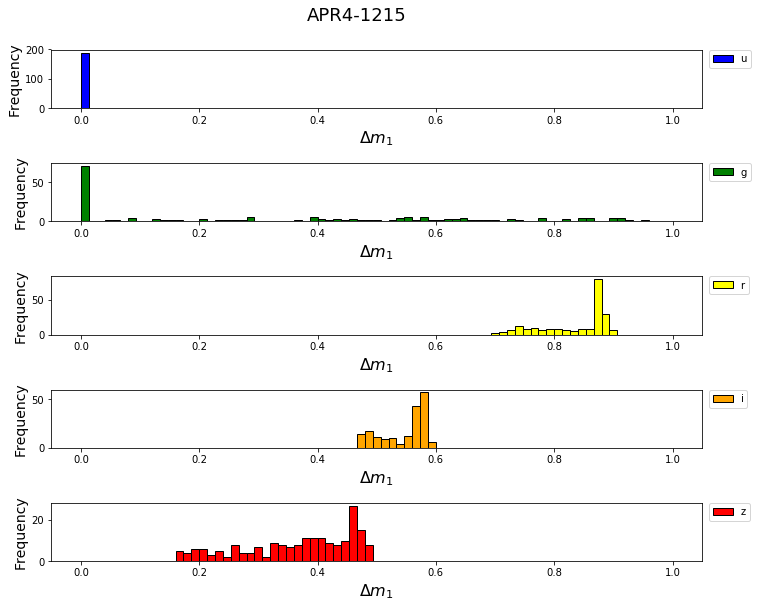

In [701]:
plot_m1(APR1215_table, 'APR4-1215')

In [704]:
plot_m1(APR1314_table, 'APR4-1314')
plt.close()

In [705]:
plot_m1(H41215_table, "H4-1215")
plt.close()

In [706]:
plot_m1(H41314_table, "H4-1314")
plt.close()

In [707]:
plot_m1(Sly135_table, "Sly-135")
plt.close()

### NS-BH $\boldsymbol{\Delta \textbf{m}_{1}}$ Plots (Detected Kilonovae)

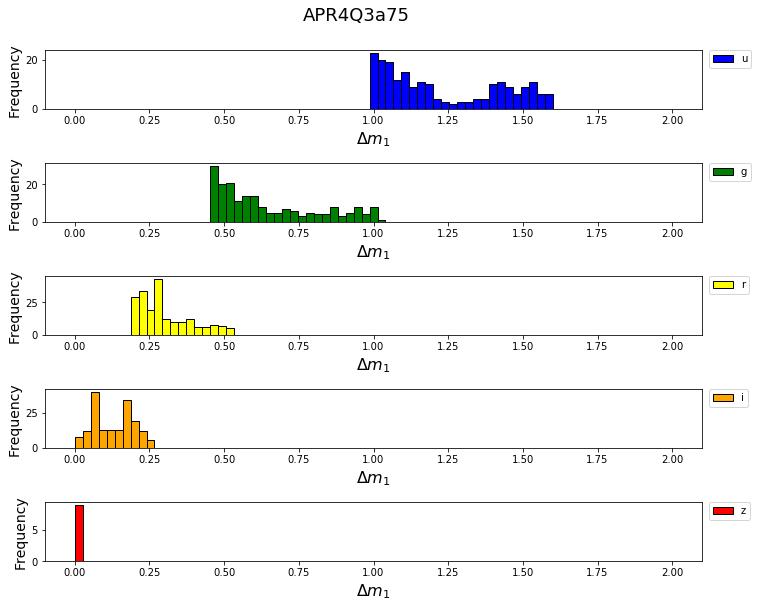

In [708]:
plot_m1(APR4Q3a75_table, "APR4Q3a75")

In [709]:
plot_m1(H4Q3a75_table, "H4Q3a75")
plt.close()

In [710]:
plot_m1(MS1Q3a75_table, "MS1Q3a75")
plt.close()

In [711]:
plot_m1(MS1Q7a75_table, "MS1Q7a75")
plt.close()

## $\boldsymbol{\Delta \textbf{m}_{\textbf{Epoch 3}}}$ Plots

In [745]:
#filter_hits: Table -> Table
#Filters the table to only have data containing kilonova hits.
def filter_hits(table):
    hits = np.where(table['Kilonova Hit'] == 1)[0]
    return table[hits]

#filter_band: Table String -> Table
#Filters the table to only have data containing the designated band.
def filter_band(table, band):
    band_filter=np.where(table['Band']==band)[0]
    return table[band_filter]


def filter_mags(table):
    return table['Magnitude\n(Epoch 1)', 'Magnitude\n(Epoch 2)', 'Magnitude\n(Epoch 3)']

def delta_m_epoch_band(table, band):
    m1 = np.subtract(filter_mags(filter_band(table, band))['Magnitude\n(Epoch 3)'],
                     filter_mags(filter_band(table, band))['Magnitude\n(Epoch 1)'])
    return m1

def plot_m_epoch(table, name):
    ax1 = plt.subplot(511)
    ax2 = plt.subplot(512)
    ax3 = plt.subplot(513)
    ax4 = plt.subplot(514)
    ax5 = plt.subplot(515)
    ax1.hist(np.array(delta_m7_band(table, 'u')),
             bins=75, range=(0, np.ceil(max_delta7(table))), facecolor='blue', edgecolor='black', label='u')
    
    ax2.hist(np.array(delta_m7_band(table, 'g')), 
             bins=75, range=(0, np.ceil(max_delta7(table))), facecolor='green', edgecolor='black', label='g')
    
    ax3.hist(np.array(delta_m7_band(table, 'r')), 
             bins=75, range=(0, np.ceil(max_delta7(table))), facecolor='yellow', edgecolor='black', label='r')
    
    ax4.hist(np.array(delta_m7_band(table, 'i')),
             bins=75, range=(0, np.ceil(max_delta7(table))), facecolor='orange', edgecolor='black', label='i')
    
    ax5.hist(np.array(delta_m7_band(table, 'z')), 
             bins=75, range=(0, np.ceil(max_delta7(table))), facecolor='red', edgecolor='black', label='z')
    
    ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax4.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax5.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.suptitle(name, fontsize=18, y=1.05)
    ax1.set_ylabel('Frequency', fontsize=14)
    ax1.set_xlabel('$Δm_{'+str(int(round(max_day(table)[0])))+'}$', fontsize=16)
    ax2.set_ylabel('Frequency', fontsize=14)
    ax2.set_xlabel('$Δm_{'+str(int(round(max_day(table)[1])))+'}$', fontsize=16)
    ax3.set_ylabel('Frequency', fontsize=14)
    ax3.set_xlabel('$Δm_{'+str(int(round(max_day(table)[2])))+'}$', fontsize=16)
    ax4.set_ylabel('Frequency', fontsize=14)
    ax4.set_xlabel('$Δm_{'+str(int(round(max_day(table)[3])))+'}$', fontsize=16)
    ax5.set_ylabel('Frequency', fontsize=14)
    ax5.set_xlabel('$Δm_{'+str(int(round(max_day(table)[4])))+'}$', fontsize=16)
    plt.tight_layout()
    return

def max_delta7(table):
    u = check_empty(np.array(delta_m7_band(table, 'u')))
    g = check_empty(np.array(delta_m7_band(table, 'g')))
    r = check_empty(np.array(delta_m7_band(table, 'r')))
    i = check_empty(np.array(delta_m7_band(table, 'i')))
    z = check_empty(np.array(delta_m7_band(table, 'z')))
    return max([u, g, r, i, z])

def check_empty(array):
    if len(array) == 0:
        max_num = 0
    else:
        max_num = max(array)
    return max_num

### NS-NS $\boldsymbol{\Delta \textbf{m}_{\textbf{Epoch 3}}}$ Plots (Detected Kilonovae)

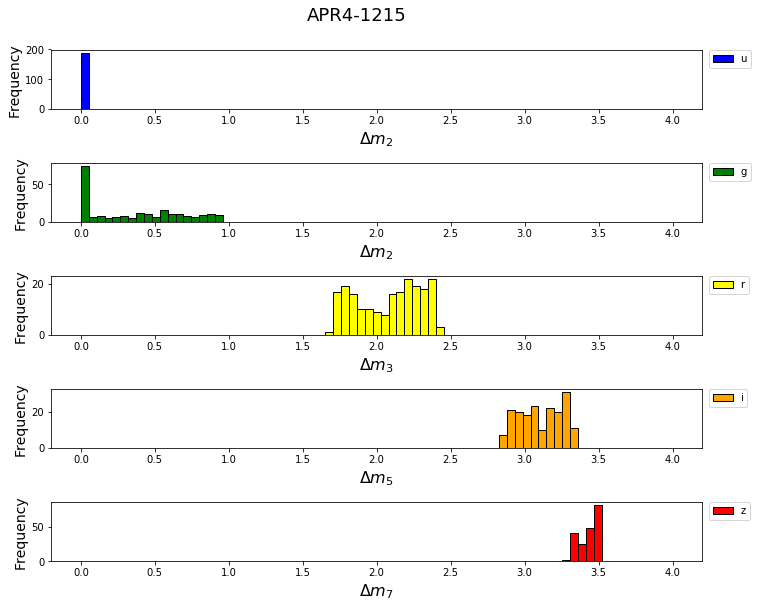

In [746]:
plot_m_epoch(APR1215_eff, 'APR4-1215')

In [752]:
plot_m_epoch(APR1314_eff, 'APR4-1314')
plt.close()

In [753]:
plot_m_epoch(H41215_eff, "H4-1215")
plt.close()

In [754]:
plot_m_epoch(H41314_eff, "H4-1314")
plt.close()

In [755]:
plot_m_epoch(Sly135_eff, "Sly-135")
plt.close()

### NS-BH $\boldsymbol{\Delta \textbf{m}_{\textbf{Epoch 3}}}$ Plots (Detected Kilonovae)

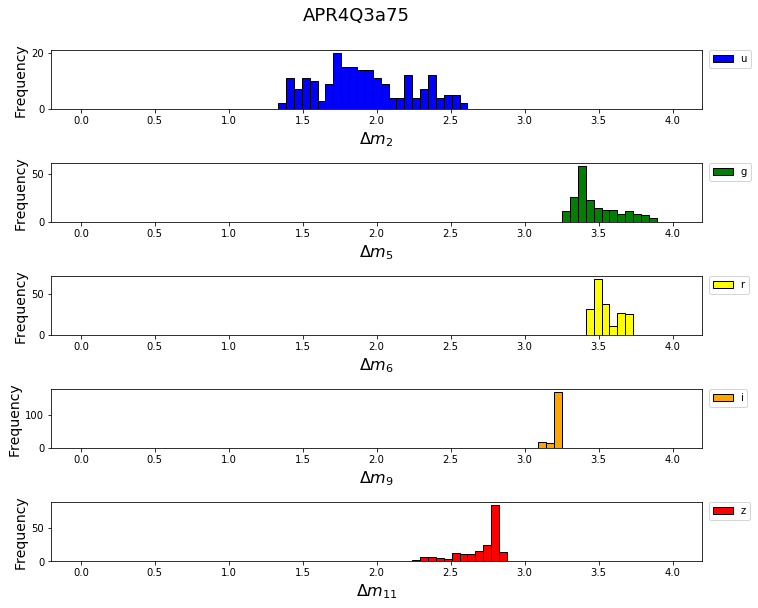

In [756]:
plot_m_epoch(APR4Q3a75_eff, "APR4Q3a75")

In [757]:
plot_m_epoch(H4Q3a75_eff, "H4Q3a75")
plt.close()

In [758]:
plot_m_epoch(MS1Q3a75_eff, "MS1Q3a75")
plt.close()

In [759]:
plot_m_epoch(MS1Q7a75_eff, "MS1Q7a75")
plt.close()